In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as ptc
import typing
import tqdm


In [2]:
np.random.seed(42)

In [3]:
def center_square(area):
  x_ = area[0]
  y_ = area[1]
  x_range = x_[1] - x_[0]
  y_range = y_[1] - y_[0]
  
  x = (x_[0] + x_range*0.25, x_[0] + x_range*0.75)
  y = (y_[0] + y_range*0.25, y_[0] + y_range*0.75)
  return (x, y)
  
def zipf(n, area):
  n_in = int(0.75*n)
  n_out = n - n_in
  
  points_out = np.random.rand(2, n_out)

  # map x and y values between minx - maxx, miny - maxy
  points_out[0, :] = np.interp(points_out[0, :], [0, 1], area[0])
  points_out[1, :] = np.interp(points_out[1, :], [0, 1], area[1])
  
  area_in = center_square(area)
  points_in = np.random.rand(2, n_in)

  # map x and y values between minx - maxx, miny - maxy
  points_in[0, :] = np.interp(points_in[0, :], [0, 1], area_in[0])
  points_in[1, :] = np.interp(points_in[1, :], [0, 1], area_in[1])
  
  points = np.concatenate((points_out, points_in), axis=1).T
  indices = np.arange(n)
  np.random.shuffle(indices)
  return points[indices]
  

In [4]:
def random_points(n_points, area, distribution_type='uniform'):
  return_var = None

  if distribution_type == 'uniform':
    x_lim = area[0]
    y_lim = area[1]
    # random uniform values between 0 - limit
    x = np.random.uniform(x_lim[0], x_lim[1], size=(n_points, 1))
    y = np.random.uniform(y_lim[0], y_lim[1], size=(n_points, 1))

    return_var = np.concatenate((x, y), axis=1)

  if distribution_type == 'zipf':
    return_var = zipf(n_points, area)

  return return_var


In [23]:
def fix_sensor_data(distribution_type='uniform'):
  sensing_radius = 20
  # Fixed_sensors
  fs_data = {'small': [], 'large': []}
  # small
  n = 30
  area = ((0, 200), (0, 200))
  sensors = random_points(n, area, distribution_type=distribution_type)
  targets_all = random_points(120, area)
  K_all = np.random.randint(low=1, high=4, size=120)
  for i in range(3, 121):
    targets = targets_all[:i]
    K = list(K_all[:i])
    fs_data['small'].append({'m' : i,
          'n' : n,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 205), (-5, 205))})

  # large
  n = 45
  area = ((0, 1000), (0, 1000))
  sensors = random_points(n, area, distribution_type=distribution_type)
  targets_all = random_points(180, area)
  K_all = np.random.randint(low=1, high=4, size=180)
  for i in range(6, 181):
    targets = targets_all[:i]
    K = list(K_all[:i])
    fs_data['large'].append({'m' : i,
          'n' : n,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 1005), (-5, 1005))})
  
  return fs_data

In [22]:
def fix_target_data(distribution_type='uniform'):
  sensing_radius = 20
  # Fixed_targets
  ft_data = {'small': [], 'large': []}
  # small
  m = 30
  area = ((0, 200), (0, 200))
  targets = random_points(m, area)
  sensors_all = random_points(120, area, distribution_type=distribution_type)
  K = list(np.random.randint(low=1, high=4, size=m))
  for i in range(3, 121):
    sensors = sensors_all[:i]
    ft_data['small'].append({'m' : m,
          'n' : i,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 205), (-5, 205))})
    
  # large
  m = 45
  area = ((0, 1000), (0, 1000))
  targets = random_points(m, area)
  sensors_all = random_points(180, area, distribution_type=distribution_type)
  K = list(np.random.randint(low=1, high=4, size=m))
  for i in range(6, 181):
    sensors = sensors_all[:i]
    ft_data['large'].append({'m' : m,
          'n' : i,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 1005), (-5, 1005))})
  
  return ft_data

In [28]:
n_data = 10

fix_sensors = []
fix_targets = []

for i in range(n_data):
  fix_sensors.append(fix_sensor_data())
  fix_targets.append(fix_target_data())


In [6]:
def make_pan_boundaries(centroid, q, radius):
    # first line always lies on x_axis 
    ans = []
    theta = 2*np.pi/q
    for i in range(q):
        x = radius*np.cos(theta*i)
        y = radius*np.sin(theta*i)
        ans.append((centroid[0] + x, centroid[1] + y))
    
    return ans
    

In [7]:
def show_network(network, sensors_mask=None, figsize=None):
    n = network['n']
    m = network['m']
    q = network['q']

    if figsize is not None:
      plt.figure(figsize=(figsize, figsize))

    margin = network['margin']

    targets = network['targets']
    sensors = network['sensors']
    radius = network['radius']

    tar_x = [i[0] for i in targets]
    tar_y = [i[1] for i in targets]
    plt.plot(tar_x, tar_y, 'r^', label='targets')
    sen_x = [i[0] for i in sensors]
    sen_y = [i[1] for i in sensors]
    plt.plot(sen_x, sen_y, 'go', label='sensors')
    ax = plt.gca()

    for i in range(len(sensors)):
        sensor = sensors[i]
        active = True

        if sensors_mask is not None:
            active = False
            if sensors_mask[i] != q:
                theta = 360.0/q
                dir = sensors_mask[i]
                active = True
                theta1, theta2 = theta*dir, theta*(dir+1)
                wedge = ptc.Wedge(sensors[i], radius, theta1, theta2, color='#34e1eb', alpha=0.4)
                ax.add_artist(wedge)
        if active:
            circle = plt.Circle(sensor, radius, color='m', fill=False, linewidth=0.4)
            ax.add_artist(circle)
            pan_boundaries = make_pan_boundaries(sensor, q, radius)
            for point in pan_boundaries:
                plt.plot([sensor[0], point[0]], [sensor[1], point[1]], 'b--', alpha=0.1)

    plt.xlim(margin[0])
    plt.ylim(margin[1])
    ax.set_aspect(1.0)  # make aspect ratio square
    
    plt.legend()

    plt.show()

In [8]:
data = generate_dataset()

In [29]:
import pickle

with open("fix_sensors.pkl", 'wb') as f:
  pickle.dump(fix_sensors, f, protocol=pickle.HIGHEST_PROTOCOL)

with open("fix_targets.pkl", 'wb') as f:
  pickle.dump(fix_targets, f, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open("data.pkl", 'rb') as f:
  nn = pickle.load(f)

In [26]:
!zip /content/fix_sensors.pkl

	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (/content/fix_sensors.pkl)


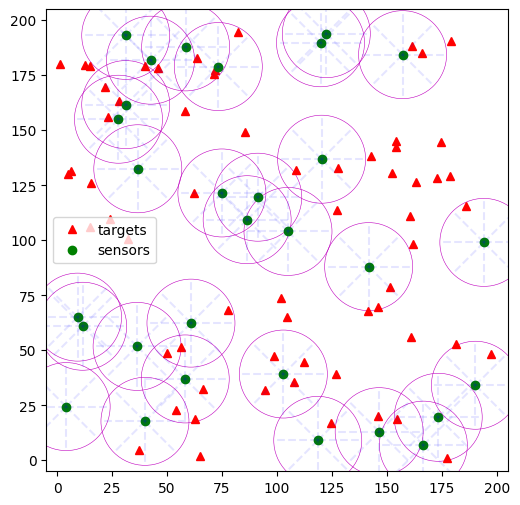

In [9]:
small_fs = data['fixed-sensor']['small']

show_network(small_fs[60], figsize=6)

In [ ]:
print(small_fs[0]['sensors'])

[[176.85357886 164.30955697]
 [ 82.16662518 107.25582494]
 [134.30056164  33.73131916]
 [ 96.78304049  67.3595243 ]
 [ 94.72613603 164.58595976]
 [129.95882535 102.51851553]
 [ 86.95617098  90.22488977]
 [  4.14181039 131.8159667 ]
 [160.10300399  70.94581904]
 [ 54.69069053   0.86159858]
 [134.27912531 188.15344724]
 [131.63274179 142.11692698]
 [ 28.92242431 191.6059907 ]
 [ 32.92659675 170.00770023]
 [ 89.56085159  74.78790206]
 [ 68.35706721  75.72257378]
 [ 54.67887256  28.84253842]
 [ 61.8538891  161.45948084]
 [ 50.88893851 123.9424151 ]
 [ 22.14866736  51.16001668]
 [ 17.57241372 192.0075725 ]
 [176.00606948 153.56076285]
 [162.97473188 176.51829758]
 [ 98.85541245  34.80508285]
 [ 63.96072426 118.51599737]
 [137.34177077 198.17261785]
 [ 21.82935291  69.89096662]
 [ 20.31399463  80.67377223]
 [ 28.22751765 107.42000742]
 [138.41584406   8.90789543]]


In [ ]:
sensors = small_fs[0]['sensors']

In [ ]:
with open('untitled.npy', 'wb') as f:
  np.save(f, sensors)

In [ ]:
rng = np.random.default_rng()
print(rng)

Generator(PCG64)


In [ ]:
rands = np.random.uniform(0, 10, size=(2, 30))

(0.3700748878927779,
 10.426739584694284,
 -0.00714798211113804,
 10.339834236597026)

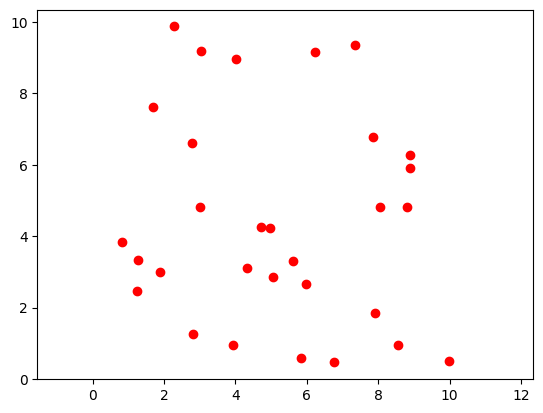

In [ ]:
plt.plot(rands[0], rands[1], 'ro')
plt.axis('equal')